# Day 18, Volumentric volcanic fallout

- https://adventofcode.com/2022/day/18

We need to count the number of surfaces of a set of cubes that are not covered by another cube. Simple, put the cubes in a set, and for each of the 6 sides check if there is a neighboring cube. We can do this with numpy and [`scipy.signal.convolve()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html#scipy.signal.convolve) to produce a count for how many sides do not have a neightbour in the 3D space.


In [1]:
from dataclasses import dataclass
from typing import Final, Self

import numpy as np
from scipy.signal import convolve

# the six sides of a cube
KERNEL: Final[np.ndarray] = np.array(
    [
        [[0, 0, 0], [0, -1, 0], [0, 0, 0]],
        [[0, -1, 0], [-1, 6, -1], [0, -1, 0]],
        [[0, 0, 0], [0, -1, 0], [0, 0, 0]],
    ]
)


@dataclass
class LavaDroplet:
    scan: np.ndarray

    @classmethod
    def from_cubes(cls, points: str) -> Self:
        coords = np.genfromtxt(points.splitlines(), delimiter=",", dtype=int)
        scan = np.zeros(tuple(coords.max(axis=0) + 1), dtype=bool)
        scan[*coords.T] = True
        return cls(scan)

    def surface_area(self) -> int:
        uncovered = convolve(self.scan, KERNEL, "same")
        return uncovered[self.scan].sum()


example = LavaDroplet.from_cubes(
    """\
2,2,2
1,2,2
3,2,2
2,1,2
2,3,2
2,2,1
2,2,3
2,2,4
2,2,6
1,2,5
3,2,5
2,1,5
2,3,5
"""
)
assert example.surface_area() == 64

In [2]:
import aocd

droplet = LavaDroplet.from_cubes(aocd.get_data(day=18, year=2022))
print("Part 1:", droplet.surface_area())

Part 1: 4332


## Part 2, filling a hole in my lava droplet

For part 2 you need to distingish inside surfaces from outside surfaces. While we could just flood-fill the (relatively small) volumetric space, I found I could use the [`scipy.ndimage.binary_fill_holes()` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_fill_holes.html#scipy-ndimage-binary-fill-holes) directly on the 3-dimensional scan matrix, and it would **fill the holes for me**.

This works because my scan matrix is just a boolean matrix with the 3d cubes acting just like pixels in an image. Because this fills the inside regions the same way that the puzzle rules state you need to penetrate the outside, the output from this function can then be directly used to calculate the surface area the same way we did in part 1.


In [3]:
from scipy.ndimage import binary_fill_holes


def outer_surface_area(droplet: LavaDroplet):
    filled = LavaDroplet(binary_fill_holes(droplet.scan))
    return filled.surface_area()


assert outer_surface_area(example) == 58

In [4]:
print("Part 2:", outer_surface_area(droplet))

Part 2: 2524


## Visualisation

This is what my lava droplet looks like:

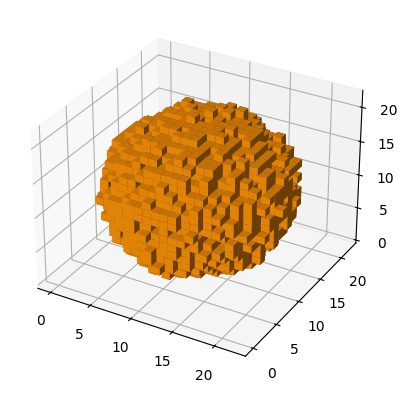

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

ax = plt.figure().add_subplot(projection="3d")
display(Markdown("## Visualisation\n\nThis is what my lava droplet looks like:"))
_ = ax.voxels(droplet.scan, facecolors="xkcd:tangerine")